In [1]:
import pandas as pd
from typing import List, Dict, Any
import statsmodels.formula.api as smf

In [2]:
url_restauration = "https://www.pxweb.bfs.admin.ch/sq/3c431fe1-16b0-4572-a8cd-ddbcfc919c5f"
url_population = "https://www.pxweb.bfs.admin.ch/sq/a2f3f03c-3b76-4dc0-890e-c6534d341848"

def restauration_employement_to_population_ratio(url_restauration : str, url_population : str) -> pd.DataFrame:
    df_restauration = pd.read_csv(url_restauration, encoding="ANSI")
    df_population = pd.read_csv(url_population, encoding="ANSI")
    df_population = df_population.groupby(["Année", "Sexe"], as_index=False)["Effectif au 1er janvier"].agg("sum")
    
    years : List[int] = [i for i in range(2010, 2025) for _ in range(8)]
    quarters : List[int] = [i for _ in range(15*2) for i in range(1, 5)]
    female : List[int] = [i for _ in range(15) for i in [1]*4+[0]*4]  # 1 if female, 0 if male
    indexes_of_columns_to_go : List[int] = [2+i for j in range((df_restauration.shape[1]-3)//4) for _ in range(2) for i in range(4*j+1, 4*j+5)] #to search efficiently in the dataframe for having the final datafram in the right format easily
    y : List[float] = []

    for index, gender, year in zip(indexes_of_columns_to_go, female, years):
        y.append(df_restauration.iloc[gender, index]/df_population.loc[df_population["Année"].eq(year)&df_population["Sexe"].eq("Femme" if gender==1 else "Homme"), "Effectif au 1er janvier"].iat[0]*100)

    dict : Dict[List[Any]] = {"Year" : years,
            "Quarters" : quarters,
            "Employment-to-population Ratio [%]" : y, 
            "Female" : female}
    return pd.DataFrame(dict)

In [3]:
df = restauration_employement_to_population_ratio(url_restauration, url_population)
df

,Year,Quarters,Employment-to-population Ratio [%],Female
0,2010,1,3.084915,1
1,2010,2,3.088478,1
2,2010,3,2.990922,1
3,2010,4,2.972550,1
4,2010,1,2.450227,0
...,...,...,...,...
115,2024,4,2.385542,1
116,2024,1,2.494324,0
117,2024,2,2.441515,0
118,2024,3,2.564543,0


In [4]:
min_year = df["Year"].min()

df["event_time_index"] = (df["Year"] - min_year) * 4 + (df["Quarters"] - 1)

# 3. Define the policy *start* in that index
#    Policy starts in 2020Q1
policy_start_index = (2020 - min_year) * 4 + (1 - 1)  # Quarter = 1 → (1-1) = 0

# 4. Event time: quarters relative to the policy start
df["event_time"] = df["event_time_index"] - policy_start_index

# Optional: an indicator for the policy window (2020Q1–2022Q2)
policy_end_index = (2022 - min_year) * 4 + (2 - 1)  # 2022Q2
df["policy_period"] = ((df["event_time_index"] >= policy_start_index) & (df["event_time_index"] <= policy_end_index)).astype(int)

## DiD

In [5]:
formula_did = '''
Q("Employment-to-population Ratio [%]") ~ Female + policy_period + Female:policy_period + C(Year) + C(Quarters)'''

simple_did = smf.ols(formula_did, data=df).fit(cov_type="HC1")
print(simple_did.summary())

                                       OLS Regression Results                                      
Dep. Variable:     Q("Employment-to-population Ratio [%]")   R-squared:                       0.813
Model:                                                 OLS   Adj. R-squared:                  0.775
Method:                                      Least Squares   F-statistic:                     25.38
Date:                                     Thu, 04 Dec 2025   Prob (F-statistic):           2.57e-30
Time:                                             11:13:26   Log-Likelihood:                 89.715
No. Observations:                                      120   AIC:                            -137.4
Df Residuals:                                           99   BIC:                            -78.89
Df Model:                                               20                                         
Covariance Type:                                       HC1                                         


## Event Study

In [6]:
formula_eventstudy = r'''Q("Employment-to-population Ratio [%]") ~ Female + C(Year) + C(Quarters) + C(event_time, Treatment(reference=-1)):Female'''

eventstudy_did = smf.ols(formula_eventstudy, data=df).fit(cov_type="HC1")
print(eventstudy_did.summary())

                                       OLS Regression Results                                      
Dep. Variable:     Q("Employment-to-population Ratio [%]")   R-squared:                       0.980
Model:                                                 OLS   Adj. R-squared:                  0.945
Method:                                      Least Squares   F-statistic:                     289.0
Date:                                     Thu, 04 Dec 2025   Prob (F-statistic):           3.81e-38
Time:                                             11:13:26   Log-Likelihood:                 225.28
No. Observations:                                      120   AIC:                            -294.6
Df Residuals:                                           42   BIC:                            -77.13
Df Model:                                               77                                         
Covariance Type:                                       HC1                                         


c:\Users\julie\anaconda3\envs\datascience_causalinference\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 77, but rank is 18
  warnings.warn('covariance of constraints does not have full '


## Plots

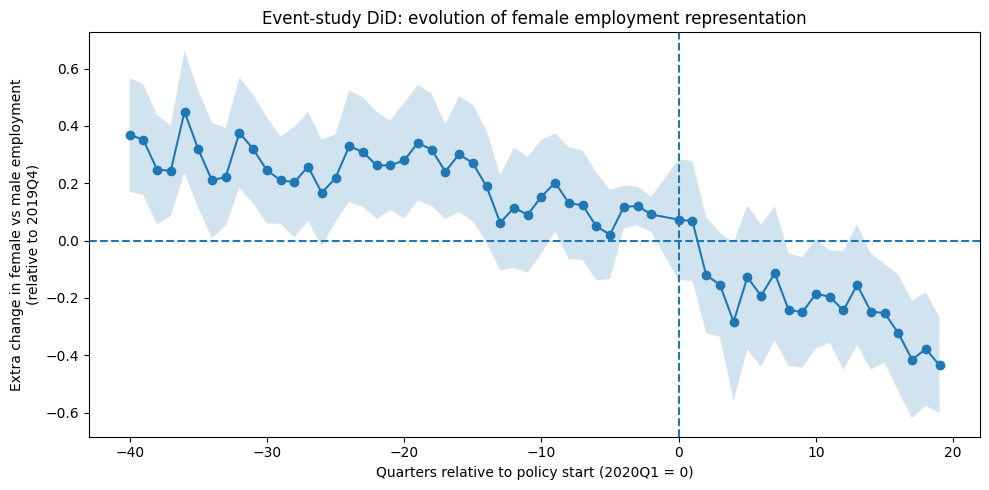

In [7]:
import re
import matplotlib.pyplot as plt

# Extract event-time × Female coefficients and their confidence intervals
coef = eventstudy_did.params
se = eventstudy_did.bse

event_time_vals = []
effects = []
lower = []
upper = []

pattern = r'C\(event_time, Treatment\(reference=-1\)\)\[T\.(-?\d+)\]:Female'

for name in coef.index:
    m = re.match(pattern, name)
    if m:
        t = int(m.group(1))
        event_time_vals.append(t)
        effects.append(coef[name])
        # 95% confidence interval
        lower.append(coef[name] - 1.96 * se[name])
        upper.append(coef[name] + 1.96 * se[name])

# Sort by event_time
order = sorted(range(len(event_time_vals)), key=lambda i: event_time_vals[i])
event_time_vals = [event_time_vals[i] for i in order]
effects = [effects[i] for i in order]
lower = [lower[i] for i in order]
upper = [upper[i] for i in order]

plt.figure(figsize=(10, 5))
plt.axhline(0, linestyle="--")  # zero line = no change vs baseline
plt.plot(event_time_vals, effects, marker="o")
plt.fill_between(event_time_vals, lower, upper, alpha=0.2)
plt.axvline(0, linestyle="--")  # vertical line at policy start
plt.xlabel("Quarters relative to policy start (2020Q1 = 0)")
plt.ylabel("Extra change in female vs male employment\n(relative to 2019Q4)")
plt.title("Event-study DiD: evolution of female employment representation")
plt.tight_layout()
plt.show()